<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/ensemble_densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
import torch


In [ ]:
from google.colab import drive # Import the google.colab.drive module

# Define your data directories
drive.mount('/content/drive') # Now you can use the drive object to mount your Google Drive
train_dir = '/content/drive/My Drive/train_imadjust_sobel_diff_alpha0.5'
val_dir = '/content/drive/My Drive/validation_imadjust_sobel_diff_alpha0.5'
test_dir = '/content/drive/My Drive/test_imadjust_sobel_diff_alpha0.5'


Mounted at /content/drive


In [ ]:
# Combine train and validation directories for cross-validation
def gather_paths_and_labels(directory):
    data = []
    for label, class_name in enumerate(['Normal', 'Scol']):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            data.append((os.path.join(class_dir, file), label))
    return np.array(data)

train_data = gather_paths_and_labels(train_dir)
val_data = gather_paths_and_labels(val_dir)
test_data = gather_paths_and_labels(test_dir)

train_val_data = np.concatenate((train_data, val_data))


In [ ]:
# Define DenseNet201 for feature extraction
def create_densenet201_feature_extractor():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Model(inputs=base_model.input, outputs=layers.GlobalAveragePooling2D()(base_model.output))
    return model

In [ ]:
# Feature extraction function
def extract_features(model, data):
    datagen = ImageDataGenerator(rescale=1./255)
    data_gen = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': data[:, 0], 'class': data[:, 1]}),
        x_col='filename', y_col='class',
        target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
    )
    features, labels = [], []
    for batch in data_gen:
        imgs, lbls = batch
        features.append(model.predict(imgs))
        labels.extend(lbls)
        if len(labels) >= len(data):
            break
    return np.vstack(features), np.array(labels)


In [ ]:
# Cross-validation function
def run_cross_validation_with_svm(data, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    feature_extractor = create_densenet201_feature_extractor()

    for fold, (train_idx, val_idx) in enumerate(skf.split(data[:, 0], data[:, 1])):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        train_files, val_files = data[train_idx], data[val_idx]

        print("Extracting features for train set...")
        train_features, train_labels = extract_features(feature_extractor, train_files)

        print("Extracting features for validation set...")
        val_features, val_labels = extract_features(feature_extractor, val_files)

        svm = SVC(kernel='linear', probability=True)
        svm.fit(train_features, train_labels)

        val_preds = svm.predict(val_features)

        acc = (val_preds == val_labels).mean()
        prec = precision_score(val_labels, val_preds)
        rec = recall_score(val_labels, val_preds)
        f1 = f1_score(val_labels, val_preds)

        accuracy_list.append(acc)
        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)

        cm = confusion_matrix(val_labels, val_preds)
        print("Confusion Matrix (Validation):")
        print(cm)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scol'], yticklabels=['Normal', 'Scol'])
        plt.title(f"Confusion Matrix - Fold {fold + 1}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    print("\n5-Fold Cross-Validation Results:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

    return svm


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

=== Fold 1/5 ===
Extracting features for train set...
Found 171 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Extracting features for validation set...
Found 43 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Confusion Matrix (Validation):
[[10  2]
 [ 0 31]]


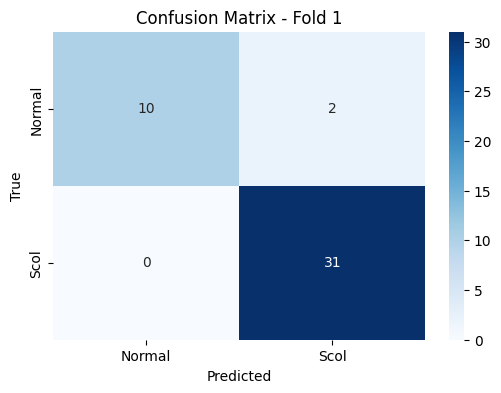


=== Fold 2/5 ===
Extracting features for train set...
Found 171 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Extracting features for validation set...
Found 43 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Confusion Matrix (Validation):
[[10  2]
 [ 0 31]]


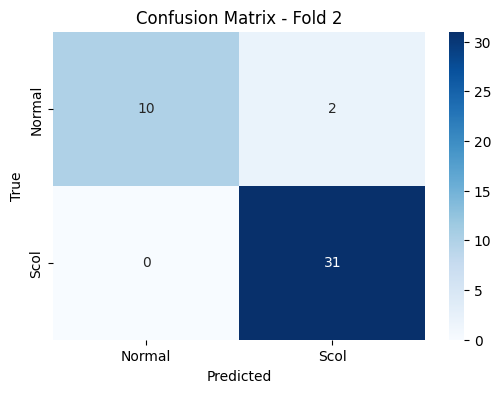


=== Fold 3/5 ===
Extracting features for train set...
Found 171 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Extracting features for validation set...
Found 43 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confusion Matrix (Validation):
[[12  0]
 [ 1 30]]


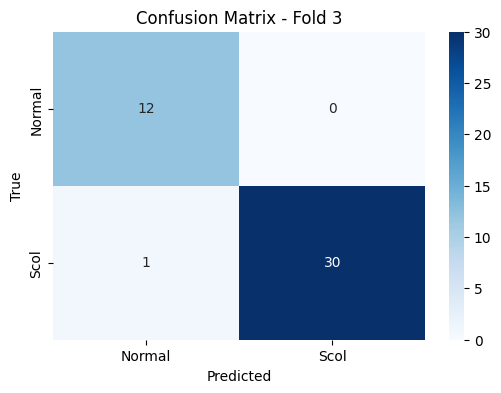


=== Fold 4/5 ===
Extracting features for train set...
Found 171 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Extracting features for validation set...
Found 43 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Confusion Matrix (Validation):
[[12  0]
 [ 2 29]]


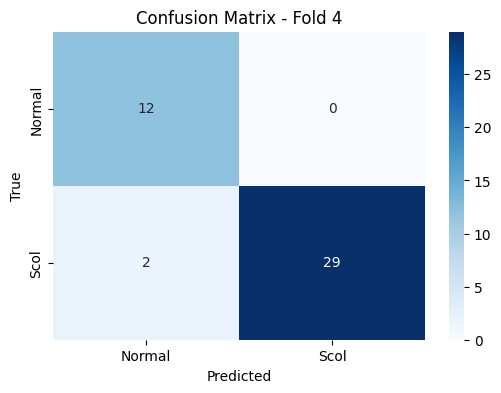


=== Fold 5/5 ===
Extracting features for train set...
Found 172 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Extracting features for validation set...
Found 42 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Confusion Matrix (Validation):
[[ 9  2]
 [ 0 31]]


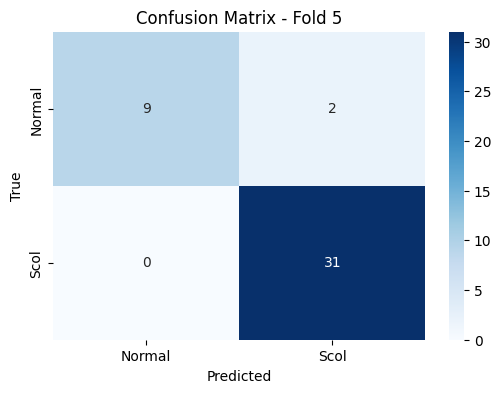


5-Fold Cross-Validation Results:
Accuracy: 0.9579 ± 0.0094
Precision: 0.9636 ± 0.0297
Recall: 0.9806 ± 0.0258
F1-Score: 0.9713 ± 0.0062


In [ ]:
# Run cross-validation
svm_model = run_cross_validation_with_svm(train_val_data)

In [ ]:
# Test set evaluation
print("Extracting features for test set...")
feature_extractor = create_densenet201_feature_extractor()
test_features, test_labels = extract_features(feature_extractor, test_data)

test_preds = svm_model.predict(test_features)


Extracting features for test set...
Found 41 validated image filenames belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step



Test Set Confusion Matrix:
[[12  0]
 [ 0 29]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        12
        Scol       1.00      1.00      1.00        29

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



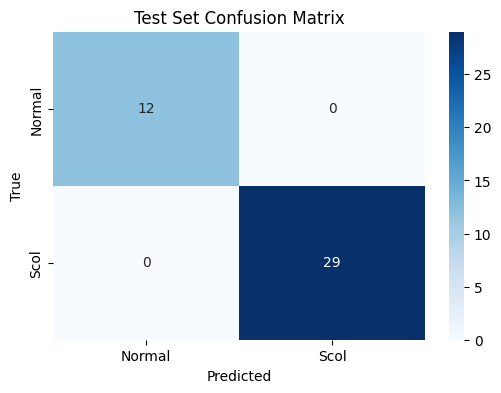

In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(test_labels, test_preds)
print("\nTest Set Confusion Matrix:")
print(cm)
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Scol']))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scol'], yticklabels=['Normal', 'Scol'])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
